## Imports

In [3]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd

from models.sphericaldeconvolution.spherical_deconvolution import spherical_deconvolution_fit
from models.sphericaldeconvolution.fibre_response_function import simple_fibre_response_function, diffusion_tensor_response_function
from dataloader.load_dt_simulated import load_dt_simulated_multiple_populations
from preprocessing.data_augmentation import extend_dataset_with_origin_reflections
from preprocessing.data_transformations import convert_coords_from_cartesian_to_spherical
from visualization.spherical_functions_visualisation import get_spherical_function_values_from_spherical_expansion
from dataloader.load_dt_simulated import load_dt_simulated_dataset, save_dt_simulated_dataset, rotate_dt_simulated_dataset
from sphericalharmonics.spherical_fourier_transform import get_spherical_fourier_transform
from sphericalharmonics.spherical_fourier_transform import get_design_matrix

# Simulated dataset generation

The complete synthetic dataset consists of diffusion weighted data (b-values, gradient orientations, diffusion weighted signals) and the SH expansion coefficients of the fODF which is the target. The simulation starts with sampling random fibre orientations and the corresponding volume fractions for predetermined number of fibre populations. Then given these directions and volume fractions fODF SH coefficients are generated as descibed before. Before the corresponding DW signals can be generated, the eigenvectors of the diffusion tensor need to be generated. Since the eigenvalues are provided as simulation parameters the first eigenvector is chosen to be the fibre population orientation. Then other two random vectors are sampled and by the process of Gram-Schmidt orthonormalization are transformed so that together with the first eigenvector they form an orthonormal basis. These vectors are then used as the eigenvectors of the diffusion tensor model and the corresponding diffusion-weighted signals are produced.

The following cell simulates dataset of 1000 voxels each with 2 fibre populations and maximum SH degree of 8.

In [2]:
dataset = load_dt_simulated_dataset(dataset_size=1000,
                                    number_of_fibre_populations=3,
                                    max_degree=8,
                                    fibre_population_eigenvalues=(0.001, 0.0003, 0.0003),
                                    number_of_data_points=90,
                                    b_value=1000,
                                    b_0_signal=1,
                                    include_b_0=False,
                                    signal_to_noise_ratio=30,
                                    noise_type='rician',
                                    noise_generator_seed=100,
                                    gradient_generator_seed=101,
                                    fibre_orientation_generator_seed=102,
                                    planar=True)

Generating fibre orientations and volume fractions...
Generating fODF spherical harmonics coefficients...
Generating diffusion tensor eigenvectors...
Simulating DW signals...
Done


The following three sections show synthetic data for one voxel.

## SH coefficients of fODF

In [3]:
dataset[0][0]

array([ 2.82094792e-01, -3.33435898e-01,  0.00000000e+00,  4.85196825e-02,
        0.00000000e+00,  3.08364485e-03, -7.22776542e-03,  0.00000000e+00,
        2.88763958e-01,  3.56870292e-18,  5.20789213e-01, -6.72233944e-18,
       -2.67051478e-03,  0.00000000e+00, -3.72656870e-01,  3.90007011e-01,
        0.00000000e+00,  5.82721078e-03,  1.18704639e-17, -2.81143512e-01,
       -7.03991424e-18,  1.95594587e-01,  1.32610347e-17,  2.60004022e-03,
        5.61978075e-19,  3.00445573e-01,  0.00000000e+00, -1.22707502e-02,
        1.83028962e-02,  0.00000000e+00, -3.03891015e-01,  3.58511373e-18,
       -5.52522366e-03, -2.22317249e-17,  2.78427086e-01,  1.04890768e-17,
        6.43061885e-01, -1.97581967e-17, -2.57491847e-03, -1.05250663e-18,
       -2.84875398e-01,  1.83765365e-17,  9.56129149e-03,  0.00000000e+00,
        3.91468230e-01])

## b-vals, gradient orientations, signals

In [4]:
dataset[1][0]

(array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000]),
 array([[-0.34892837,  0.84016363,  0.80171363,  0.46925117, -0.94875019,
         -0.72393991, -0.27039548,  0.97533909, -0.89614819,  0.63295297,
         -0.67256585,  0.18952128,  0.28050044,  0.11942255,  0.65302975,
         -0.70884899,  0.45763535,  0.95936627, -0.28829319,  0.70407638,
         -0.5054418 ,  0.13089585, -0.50394381, -0.40237737, -0.54527919,
         -0.1124

## Fibre orientations

In [5]:
dataset[2][0]

array([[ 0.65296877, -0.75738483,  0.        ],
       [-0.745707  ,  0.66627402,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

## Plot simulated fODF

Fibre orientations
[[ 0.36855622  0.92960546  0.        ]
 [-0.81407601  0.58075833  0.        ]
 [ 0.          0.          1.        ]]


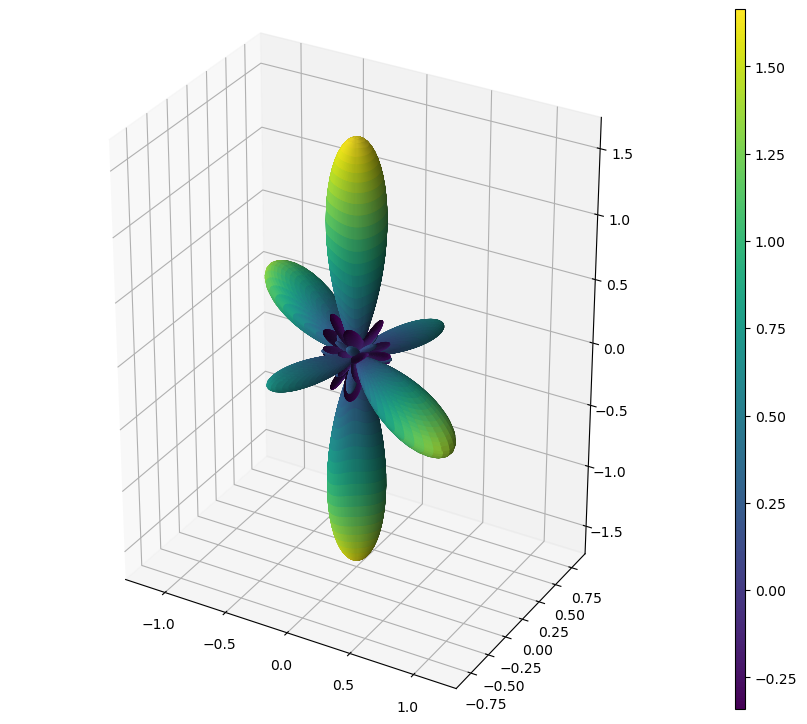

In [6]:
fODFs = dataset[0]
fibre_orientations = dataset[2]

# Change here to plot different fODF
index = 6

# Volume fractions for index 6
# [0.19228589010115282, 0.37412744866771697, 0.43358666123113027]

print('Fibre orientations')
print(fibre_orientations[index])

x, y, z, fcolors = get_spherical_function_values_from_spherical_expansion(fODFs[index],max_degree=8,resolution=200,min_value=None,max_value=None, normalize=False)

x = x * fcolors
y = y * fcolors
z = z * fcolors

fig = plt.figure(figsize=(10,10))

cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(fcolors), vmax=np.max(fcolors))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=plt.cm.viridis(normalization(fcolors)), shade=True)
#ax.set_axis_off()
plt.gca().set_aspect('equal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()

## Plot the corresponding fibre orientations

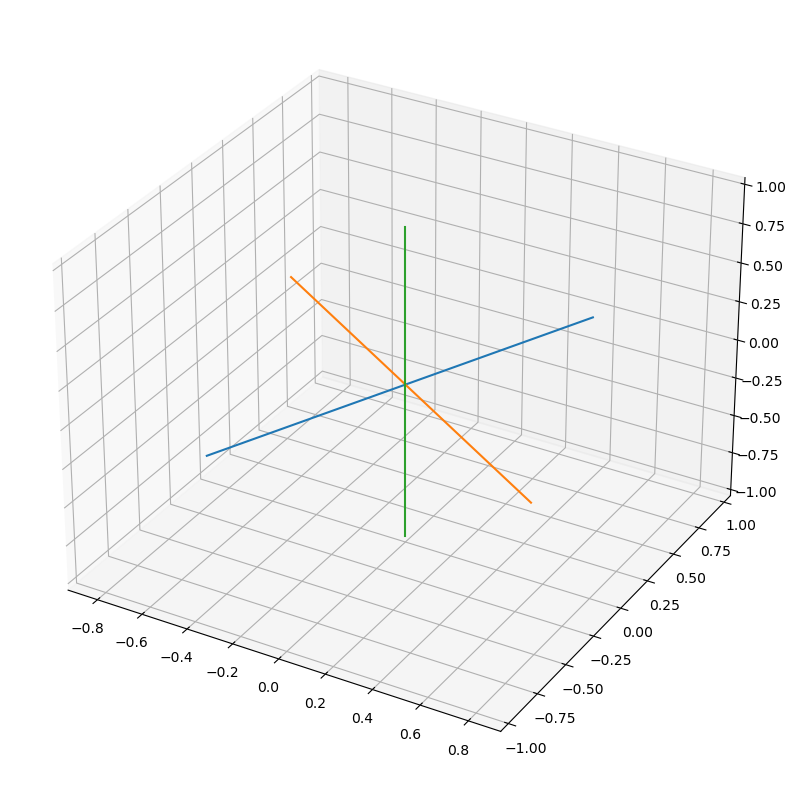

In [7]:
#%matplotlib qt
fibre_orientations_to_be_plotted = fibre_orientations[index]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot([-fibre_orientations_to_be_plotted[0,0],fibre_orientations_to_be_plotted[0,0]], [-fibre_orientations_to_be_plotted[0,1],fibre_orientations_to_be_plotted[0,1]], [-fibre_orientations_to_be_plotted[0,2],fibre_orientations_to_be_plotted[0,2]])
ax.plot([-fibre_orientations_to_be_plotted[1,0],fibre_orientations_to_be_plotted[1,0]], [-fibre_orientations_to_be_plotted[1,1],fibre_orientations_to_be_plotted[1,1]], [-fibre_orientations_to_be_plotted[1,2],fibre_orientations_to_be_plotted[1,2]])
ax.plot([-fibre_orientations_to_be_plotted[2,0],fibre_orientations_to_be_plotted[2,0]], [-fibre_orientations_to_be_plotted[2,1],fibre_orientations_to_be_plotted[2,1]], [-fibre_orientations_to_be_plotted[2,2],fibre_orientations_to_be_plotted[2,2]])
plt.show()

## Generate dataset without rotations

This dataset is used to demonstrate the equivariance in outputs of the S-CNN. The fibre orientations in this dataset are restricted such that two populations lie on the $xy$-plane and the third population is aligned with the $z$ axis (as can be seen in the figure above).

In [8]:
dataset = load_dt_simulated_dataset(dataset_size=1000000,
                                    number_of_fibre_populations=3,
                                    max_degree=8,
                                    fibre_population_eigenvalues=(0.001, 0.0003, 0.0003),
                                    number_of_data_points=90,
                                    b_value=1000,
                                    b_0_signal=1,
                                    include_b_0=False,
                                    signal_to_noise_ratio=30,
                                    noise_type='rician',
                                    noise_generator_seed=100,
                                    gradient_generator_seed=101,
                                    fibre_orientation_generator_seed=102,
                                    planar=True)

Generating fibre orientations and volume fractions...
Generating fODF spherical harmonics coefficients...
Generating diffusion tensor eigenvectors...
Simulating DW signals...
Done


### Save the dataset

In [1]:
path = './data2/planar/no_rotation'

In [9]:
save_dt_simulated_dataset(dataset, path)

### Compute SH coefficients of DW signals

In [10]:
all_dwis = np.load(path+'/diffusion_weighted_signals.npy')
all_qhat = np.load(path+'/gradient_orientations.npy')
all_bvals = np.load(path+'/b_values.npy')
all_dwis_sh_coefficients = []

for i in range(len(all_dwis)):
    bvals, qhat, dwis = extend_dataset_with_origin_reflections(all_bvals[i], all_qhat[i], all_dwis[i])
    thetas, phis = convert_coords_from_cartesian_to_spherical(qhat)
    
    design_matrix = get_design_matrix(max_degree = 8, number_of_samples=len(dwis), thetas=thetas, phis=phis)
    spherical_fourier_transform = get_spherical_fourier_transform(design_matrix)
    expansion_coefficients = spherical_fourier_transform @ dwis
    
    all_dwis_sh_coefficients.append(expansion_coefficients)

all_dwis_sh_coefficients = np.array(all_dwis_sh_coefficients)

### Save the SH coefficients of DW signals

In [11]:
np.save(path+'/diffusion_weighted_signals_sh_coefficients', all_dwis_sh_coefficients)

## Generate dataset with roatations

This dataset follows the same restrictions as the preceding one. However this time an $SO(3)$ rotation is applied to each set of measurements. This is used to demonstrate that S-CNN is able to recognize rotated measurements.

In [4]:
fibre_orientations = np.load(path+'/fibre_orientations.npy')

rotated_dataset = rotate_dt_simulated_dataset(fibre_orientations,
                                              number_of_fibre_populations=3,
                                              max_degree=8,
                                              fibre_population_eigenvalues=(0.001, 0.0003, 0.0003),
                                              number_of_data_points=90,
                                              b_value=1000,
                                              b_0_signal=1,
                                              include_b_0=False,
                                              signal_to_noise_ratio=30,
                                              noise_type='rician',
                                              noise_generator_seed=100,
                                              gradient_generator_seed=101,
                                              fibre_orientation_generator_seed=102)

### Save the dataset

In [5]:
path_rotated = './data2/planar/rotation'
        
save_dt_simulated_dataset(rotated_dataset, path_rotated)

### Compute SH coefficients of rotated DW signals

In [7]:
all_dwis_rotated = np.load(path_rotated+'/diffusion_weighted_signals.npy')
all_qhat_rotated = np.load(path_rotated+'/gradient_orientations.npy')
all_bvals_rotated = np.load(path_rotated+'/b_values.npy')
all_dwis_sh_coefficients_rotated = []

for i in range(len(all_dwis_rotated)):
    bvals, qhat, dwis = extend_dataset_with_origin_reflections(all_bvals_rotated[i], all_qhat_rotated[i], all_dwis_rotated[i])
    thetas, phis = convert_coords_from_cartesian_to_spherical(qhat)
    
    design_matrix = get_design_matrix(max_degree = 8, number_of_samples=len(dwis), thetas=thetas, phis=phis)
    spherical_fourier_transform = get_spherical_fourier_transform(design_matrix)
    expansion_coefficients = spherical_fourier_transform @ dwis
    
    all_dwis_sh_coefficients_rotated.append(expansion_coefficients)

all_dwis_sh_coefficients_rotated = np.array(all_dwis_sh_coefficients_rotated)

### Save the SH coefficients of rotated DW signals

In [8]:
np.save(path_rotated+'/diffusion_weighted_signals_sh_coefficients', all_dwis_sh_coefficients_rotated)

### Plot rotated fODF

Fibre orientations
[[ 0.80457141 -0.40948231 -0.43010357]
 [ 0.53788534 -0.33939891  0.77167852]
 [-0.47585482 -0.87783961 -0.0544041 ]]


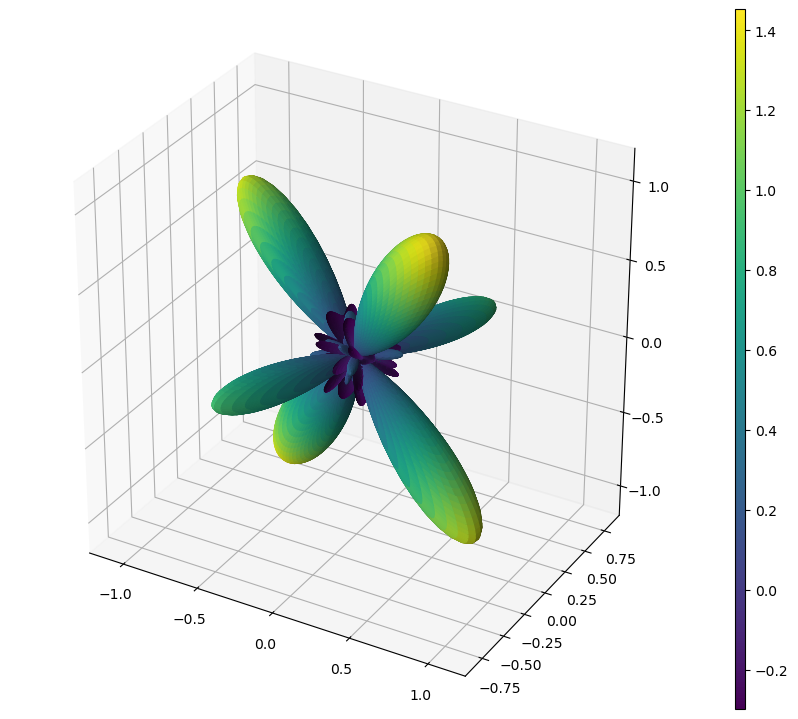

In [10]:
fODFs_rotated = rotated_dataset[0]
fibre_orientations_rotated = rotated_dataset[2]

# Change here to plot different fODF
index = 6

print('Fibre orientations')
print(fibre_orientations_rotated[index])

x, y, z, fcolors = get_spherical_function_values_from_spherical_expansion(fODFs_rotated[index],max_degree=8,resolution=200,min_value=None,max_value=None, normalize=False)

x = x * fcolors
y = y * fcolors
z = z * fcolors

fig = plt.figure(figsize=(10,10))

cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(fcolors), vmax=np.max(fcolors))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=plt.cm.viridis(normalization(fcolors)), shade=True)
#ax.set_axis_off()
plt.gca().set_aspect('equal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()